In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.474198 -0.756705 -0.555499  0.425864  0.108020 -0.558135 -0.861011   
  1  -0.354104 -0.217603  0.482984  0.520714  0.665563  0.764772 -0.701369   
  2   0.372720 -0.518789 -0.377706  0.260719  0.760284 -0.319930 -1.130052   
  3   1.004084 -0.068838  0.315981 -0.461979 -0.401715  0.302945 -0.533160   
  4  -1.311415 -0.488580 -0.558747  0.349048 -0.311707 -0.253357 -0.033429   
  5   0.594369 -1.258752  0.035387  0.354519 -0.189880 -0.829617 -0.083815   
  6  -0.008119  0.129517 -0.240414 -0.255615 -0.227957 -0.128972 -0.930294   
  7   0.158140 -1.172931 -1.471245  0.031077  0.306260 -0.662552 -0.278175   
  8  -0.952272 -0.705578 -0.255837  0.036215 -0.288381  0.591188  0.258264   
  9   0.314405  0.325046  0.346699  0.321656  0.373002 -0.272139 -0.306263   
  10 -0.383267  0.138792 -0.389663 -0.358024 -0.574903 -0.044583 -1.548168   
  11 -0.050346 -0.752973 -0.394598  0.080681  0.177803 -0.523371 -0.136907   
  12  1.002710 -0.061775  0.196798 -0.392642  0.055045  1.131387 -0.575229   
  13 -0.335920  0.345088 -0.238274  0.075570  0.424432  0.366846 -0.050640   
  14  0.342079  0.517521 -0.551591  0.361451 -0.211638  0.532786 -0.396717   
  15 -0.822944 -0.567612  0.311765  0.179234  0.247806  0.639488  0.946740   
  16 -0.881240 -1.217799 -0.203100  0.028721 -0.261212 -0.628374 -0.708981   
  17 -1.170098 -0.765986 -0.774882  0.925038  0.605405  0.289755  0.126234   
  18 -0.498515 -0.283327 -1.557327 -1.286361 -0.283374 -0.714908 -0.583365   
  19 -0.472527 -0.186981 -0.790140  0.152203 -0.246898  0.907256  0.155426   
  20  0.511379  0.174454  0.024519  0.589412  0.457074  0.024472 -0.978011   
  21 -0.363550  0.138214 -0.105334 -0.745090 -1.025195 -0.214558 -0.773069   
  22 -0.939404 -0.121780 -0.511158 -0.639797 -0.078561 -0.449453 -0.035326   
  23 -0.040167  0.901540  0.302161  0.357068  1.026050  0.021861 -0.375211   
  24 -0.101786  0.466063 -0.880003 -0.865624  0.144794 -0.451939  0.166569   
1 0  -0.318302  0.274711  0.213315 -0.297103 -0.270163 -0.221279 -1.148943   
  1  -0.128070 -0.456203  0.171316 -0.306719  0.671937 -0.139691 -0.269004   
  2   0.210832  0.262455 -0.008738 -0.142741  0.197703 -0.467491  0.561882   
  3  -1.056397  0.190515  0.173509 -0.932635 -0.790497 -0.382197  0.145997   
  4  -0.810238 -0.667775 -0.583547 -0.318595 -0.959699 -1.126288 -0.268093   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.697354 -0.275161  1.049129  ...  0.470735 -0.045651  0.782122   
  1   1.297410  0.531271  1.208758  ...  0.560608 -0.482411  0.043538   
  2   0.060048 -0.942620  0.281474  ... -0.603071 -0.013743  0.238587   
  3   0.405655 -0.649019  0.193991  ...  0.483104  0.355273 -0.923466   
  4  -0.024619 -0.394654  0.214231  ...  0.498490  0.464030  0.300200   
  5   0.760394  0.066870  0.632201  ...  1.274271  1.200008  0.926924   
  6   0.119536  0.144221  1.316910  ...  0.589484  0.599736  0.847378   
  7   0.326670 -0.595647  0.300306  ...  0.601511  0.201829  1.530152   
  8   0.269454  0.574617  0.875243  ...  0.677733  0.589548  0.988429   
  9   0.806140 -0.539364  0.247370  ...  0.942236 -0.085973  0.913763   
  10  0.550068 -0.796769  0.158395  ...  0.491066 -0.599751  0.061520   
  11  0.066506  0.431166  0.900035  ...  0.263339 -0.182137 -0.214739   
  12 -0.000098  0.100733  0.691528  ...  0.259039 -0.178238  0.912605   
  13  0.532891  1.121891  0.482170  ...  0.733937  0.428728  0.300549   
  14 -0.916089 -1.176038 -0.822308  ...  0.565513 -1.202097 -0.672962   
  15  1.279710 -0.587531 -0.288813  ...  0.055440  0.016559 -0.649547   
  16  0.063973  0.189180 -0.392939  ...  0.928149 -0.440223  1.127556   
  17  0.144434 -1.030116  0.549548  ...  0.413549  0.019116  0.017371   
  18 -0.304517 -1.238757  0.120352  ...  0.030069  0.202002  0.325240   
  19  0.327582 -0.560244  0.265246  ...  1.056842  0.370867  0.848412   
  20  0.378266 -0.846522 -0.294230  ... -0.141845 -0.294993 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.054497  0.041776  25.241601  1.400544e-140  0.972617  1.136376


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



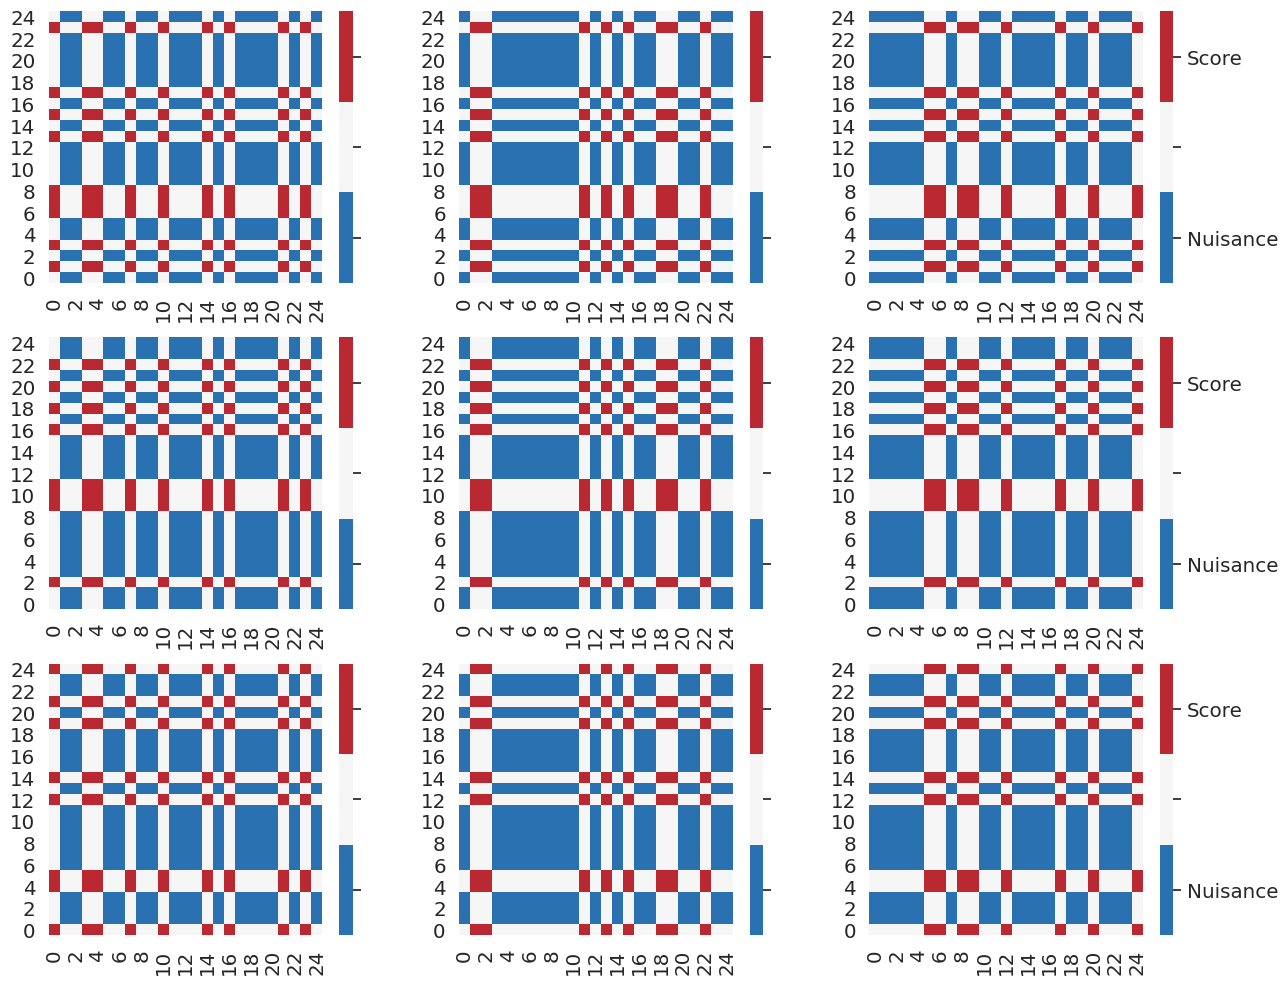

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



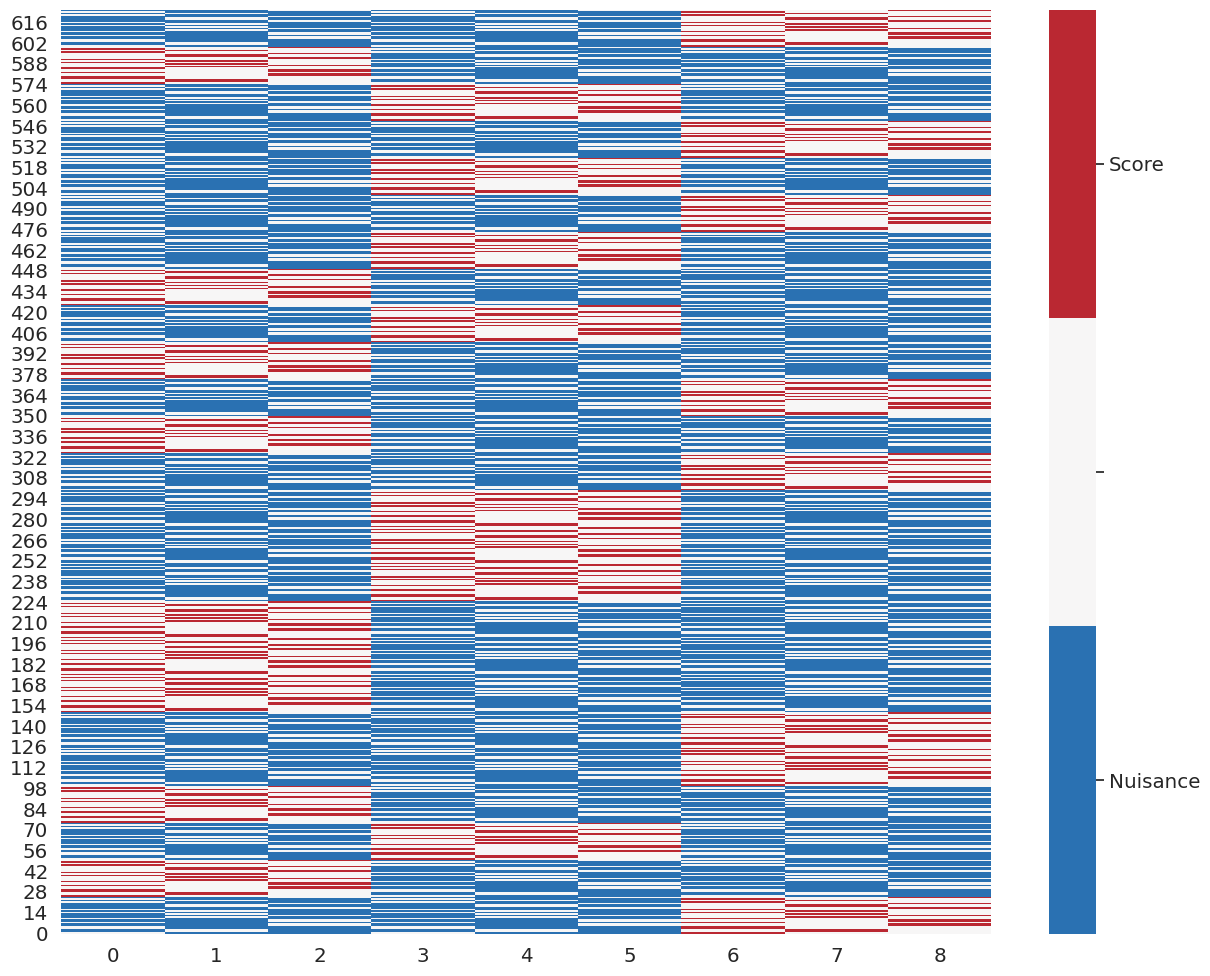

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])